In [16]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report




In [17]:
# Get underlying prices
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [18]:
target = pd.read_csv("../data/processed/target.csv", index_col = 0)

In [19]:
target

,target
0,1
1,1
2,1
3,1
4,1
...,...
1248,0
1249,0
1250,0
1251,0


In [20]:
# Get the working dataframe
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [21]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

## Baseline Random Forest Classifier without new data

In [22]:
orig_df = ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff_date"]].copy()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(orig_df.values, target.values.flatten(), test_size=0.2, random_state=1968)

In [24]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('rf', RandomForestClassifier())])

In [25]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 25)]
# Number of features to consider at every split
max_features = [None, 'sqrt', "log2"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion = ["gini", "entropy", "log_loss"]
# Create the random grid
random_grid = {'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap, 
               'rf__criterion':criterion,
               }


In [26]:
n_iter = 200
verbose_level = 1
n_jobs = 4

In [27]:
# Grid search
rf_random = RandomizedSearchCV(estimator = pipe, param_distributions = random_grid, n_iter = n_iter, cv = 5, verbose=verbose_level, random_state=1968, n_jobs = n_jobs)

In [28]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(fill_value=0.0,
                                                            strategy='constant')),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=200, n_jobs=4,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__criterion': ['gini', 'entropy',
                                                          'log_loss'],
                                        'rf__max_depth': [2, 4, 6, 8, 10, 12,
                                                          14, 16, 18, 20,
                                                          None],
                                        'rf__max_features': [None, 'sqrt',
                                                             'log2'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [10, 17, 25, 33, 41,
                                                             49, 57, 65, 73, 81,
                                                             89, 97, 105, 112,
                                                             120, 128, 136, 144,
                                                             152, 160, 168, 176,
                                                             184, 192, 200]},
                   random_state=1968, verbose=1)

In [29]:
rf_random.best_params_

{'rf__n_estimators': 160,
 'rf__min_samples_split': 5,
 'rf__min_samples_leaf': 1,
 'rf__max_features': 'log2',
 'rf__max_depth': 12,
 'rf__criterion': 'gini',
 'rf__bootstrap': True}

In [30]:
pd.DataFrame.from_dict(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__criterion,param_rf__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
70,0.576166,0.009037,0.020255,0.003445,160,5,1,log2,12,gini,True,"{'rf__n_estimators': 160, 'rf__min_samples_spl...",0.651741,0.706468,0.725,0.685,0.665,0.686642,0.026659,1
81,0.687212,0.001956,0.016852,0.003451,112,5,2,None,12,gini,True,"{'rf__n_estimators': 112, 'rf__min_samples_spl...",0.631841,0.696517,0.725,0.680,0.680,0.682672,0.030270,2
40,0.466575,0.005630,0.015233,0.001467,136,5,4,log2,16,gini,True,"{'rf__n_estimators': 136, 'rf__min_samples_spl...",0.656716,0.701493,0.710,0.685,0.660,0.682642,0.021420,3
169,0.742245,0.028750,0.017301,0.001132,120,2,4,None,14,gini,True,"{'rf__n_estimators': 120, 'rf__min_samples_spl...",0.651741,0.706468,0.725,0.650,0.680,0.682642,0.029628,3
190,1.450090,0.037664,0.019927,0.005019,152,5,1,None,20,entropy,True,"{'rf__n_estimators': 152, 'rf__min_samples_spl...",0.661692,0.686567,0.715,0.665,0.675,0.680652,0.019242,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0.174586,0.005567,0.010115,0.001625,89,10,1,log2,2,log_loss,False,"{'rf__n_estimators': 89, 'rf__min_samples_spli...",0.542289,0.552239,0.555,0.545,0.545,0.547905,0.004849,196
166,0.202517,0.010787,0.010700,0.001266,97,5,4,sqrt,2,entropy,True,"{'rf__n_estimators': 97, 'rf__min_samples_spli...",0.542289,0.577114,0.530,0.535,0.550,0.546881,0.016559,197
148,0.257758,0.012027,0.012366,0.002147,120,5,2,log2,2,gini,True,"{'rf__n_estimators': 120, 'rf__min_samples_spl...",0.512438,0.567164,0.540,0.545,0.560,0.544920,0.018982,198
60,0.210967,0.010185,0.007608,0.001730,73,10,1,None,2,gini,True,"{'rf__n_estimators': 73, 'rf__min_samples_spli...",0.552239,0.567164,0.510,0.545,0.540,0.542881,0.018821,199


In [31]:
best_model = rf_random.best_estimator_

In [32]:
best_model.score(X_test, y_test)

0.6653386454183267

In [33]:
predictions = best_model.predict(X_test)

In [34]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.64      0.72      0.68       124
           1       0.69      0.61      0.65       127

    accuracy                           0.67       251
   macro avg       0.67      0.67      0.66       251
weighted avg       0.67      0.67      0.66       251



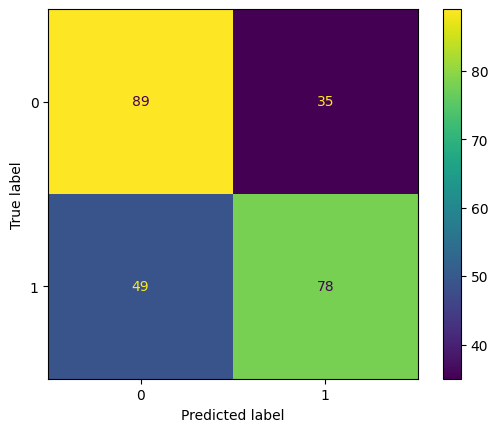

In [35]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

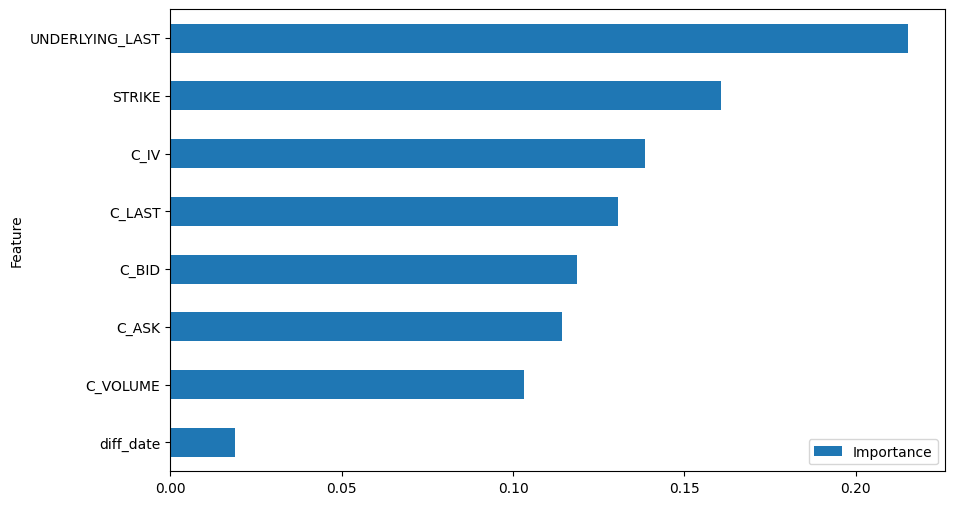

In [36]:
coefficients = best_model.named_steps["rf"].feature_importances_

feature_importance = pd.DataFrame({'Feature': orig_df.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## Random Forest with data from MC simulation

In [37]:
new_df = pd.concat((ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff"]],wk_df.drop(["last_quote", "strike"], axis=1) ), axis=1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(new_df.values, target.values.flatten(), test_size=0.2, random_state=1968)

In [39]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('rf', RandomForestClassifier())])

In [40]:
# Grid search
rf_random = RandomizedSearchCV(estimator = pipe, param_distributions = random_grid, n_iter = n_iter, cv = 5, verbose=verbose_level, random_state=1968, n_jobs = n_jobs)

In [41]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(fill_value=0.0,
                                                            strategy='constant')),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=200, n_jobs=4,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__criterion': ['gini', 'entropy',
                                                          'log_loss'],
                                        'rf__max_depth': [2, 4, 6, 8, 10, 12,
                                                          14, 16, 18, 20,
                                                          None],
                                        'rf__max_features': [None, 'sqrt',
                                                             'log2'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [10, 17, 25, 33, 41,
                                                             49, 57, 65, 73, 81,
                                                             89, 97, 105, 112,
                                                             120, 128, 136, 144,
                                                             152, 160, 168, 176,
                                                             184, 192, 200]},
                   random_state=1968, verbose=1)

In [42]:
rf_random.best_params_

{'rf__n_estimators': 65,
 'rf__min_samples_split': 5,
 'rf__min_samples_leaf': 4,
 'rf__max_features': 'sqrt',
 'rf__max_depth': None,
 'rf__criterion': 'entropy',
 'rf__bootstrap': False}

In [43]:
pd.DataFrame.from_dict(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__criterion,param_rf__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
199,0.488640,0.009124,0.010294,0.001006,65,5,4,sqrt,None,entropy,False,"{'rf__n_estimators': 65, 'rf__min_samples_spli...",0.781095,0.741294,0.775,0.750,0.770,0.763478,0.015228,1
141,0.634498,0.017897,0.014440,0.002165,105,5,1,sqrt,20,entropy,True,"{'rf__n_estimators': 105, 'rf__min_samples_spl...",0.771144,0.746269,0.760,0.750,0.765,0.758483,0.009233,2
157,0.598679,0.016248,0.016746,0.001362,128,5,2,sqrt,20,gini,True,"{'rf__n_estimators': 128, 'rf__min_samples_spl...",0.761194,0.756219,0.750,0.745,0.765,0.755483,0.007262,3
68,1.344295,0.048052,0.022940,0.002627,184,10,2,sqrt,14,log_loss,False,"{'rf__n_estimators': 184, 'rf__min_samples_spl...",0.781095,0.746269,0.755,0.735,0.755,0.754473,0.015204,4
66,0.868469,0.027121,0.014288,0.001611,128,2,4,log2,14,entropy,False,"{'rf__n_estimators': 128, 'rf__min_samples_spl...",0.761194,0.736318,0.765,0.735,0.760,0.751502,0.013048,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,0.180857,0.007207,0.008312,0.000999,89,2,2,log2,2,gini,False,"{'rf__n_estimators': 89, 'rf__min_samples_spli...",0.592040,0.592040,0.510,0.590,0.555,0.567816,0.032164,196
176,0.219393,0.013751,0.010744,0.002594,73,10,1,log2,2,log_loss,True,"{'rf__n_estimators': 73, 'rf__min_samples_spli...",0.577114,0.567164,0.560,0.575,0.555,0.566856,0.008476,197
3,0.125213,0.007910,0.005772,0.000814,49,5,1,sqrt,2,entropy,True,"{'rf__n_estimators': 49, 'rf__min_samples_spli...",0.601990,0.547264,0.545,0.570,0.550,0.562851,0.021493,198
135,0.253430,0.011447,0.011939,0.003023,105,5,1,log2,2,gini,True,"{'rf__n_estimators': 105, 'rf__min_samples_spl...",0.621891,0.562189,0.495,0.555,0.555,0.557816,0.040215,199


In [44]:
best_model = rf_random.best_estimator_

In [45]:
best_model.score(X_test, y_test)

0.7450199203187251

In [46]:
predictions = best_model.predict(X_test)

In [47]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       124
           1       0.76      0.72      0.74       127

    accuracy                           0.75       251
   macro avg       0.75      0.75      0.74       251
weighted avg       0.75      0.75      0.74       251



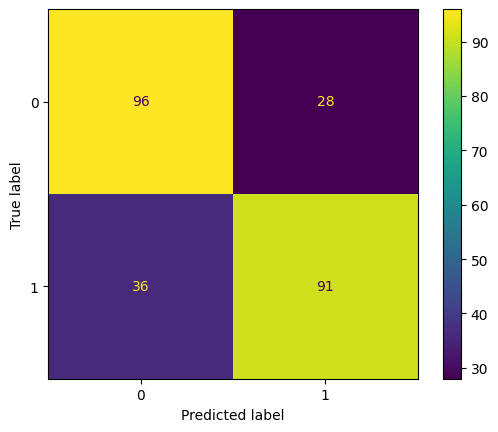

In [48]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

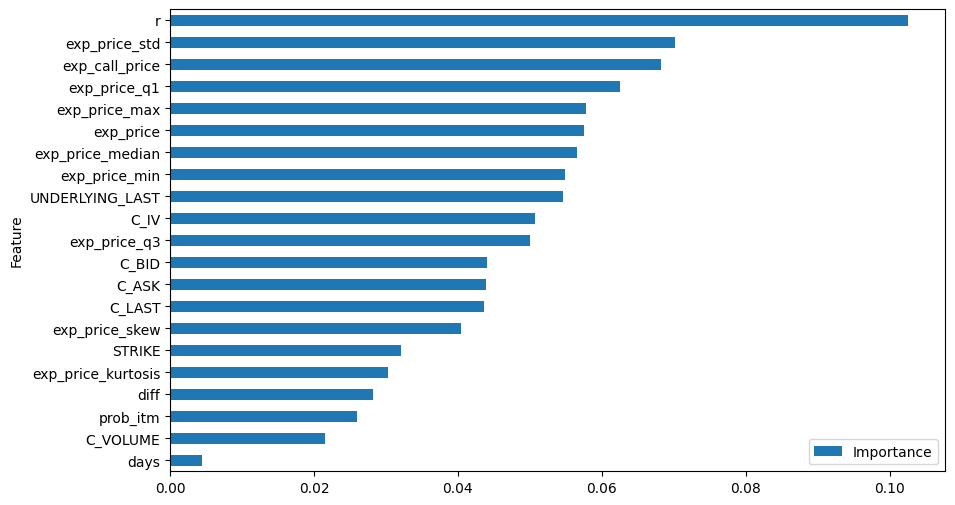

In [49]:
coefficients = best_model.named_steps["rf"].feature_importances_

feature_importance = pd.DataFrame({'Feature': new_df.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## Random Forest with data from MC simulation and some addtional features

In [50]:
new_df = pd.concat((ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff"]],wk_df.drop(["last_quote", "strike"], axis=1) ), axis=1)

In [51]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"]-new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"]-new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"],2)
new_df["exp_profit"] = new_df["exp_price"]-(new_df["UNDERLYING_LAST"]+new_df["C_LAST"])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(new_df.values, target.values.flatten(), test_size=0.2, random_state=1968)

In [56]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('rf', RandomForestClassifier())])

In [57]:
# Grid search
rf_random = RandomizedSearchCV(estimator = pipe, param_distributions = random_grid, n_iter = n_iter, cv = 5, verbose=verbose_level, random_state=1968, n_jobs = n_jobs)

In [58]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(fill_value=0.0,
                                                            strategy='constant')),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=200, n_jobs=4,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__criterion': ['gini', 'entropy',
                                                          'log_loss'],
                                        'rf__max_depth': [2, 4, 6, 8, 10, 12,
                                                          14, 16, 18, 20,
                                                          None],
                                        'rf__max_features': [None, 'sqrt',
                                                             'log2'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [10, 17, 25, 33, 41,
                                                             49, 57, 65, 73, 81,
                                                             89, 97, 105, 112,
                                                             120, 128, 136, 144,
                                                             152, 160, 168, 176,
                                                             184, 192, 200]},
                   random_state=1968, verbose=1)

In [59]:
rf_random.best_params_

{'rf__n_estimators': 81,
 'rf__min_samples_split': 2,
 'rf__min_samples_leaf': 2,
 'rf__max_features': 'sqrt',
 'rf__max_depth': 14,
 'rf__criterion': 'log_loss',
 'rf__bootstrap': False}

In [60]:
pd.DataFrame.from_dict(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__criterion,param_rf__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
168,0.717257,0.017438,0.011853,0.003591,81,2,2,sqrt,14,log_loss,False,"{'rf__n_estimators': 81, 'rf__min_samples_spli...",0.796020,0.736318,0.755,0.755,0.745,0.757468,0.020500,1
103,0.606164,0.020286,0.013831,0.003812,89,2,1,sqrt,None,log_loss,True,"{'rf__n_estimators': 89, 'rf__min_samples_spli...",0.781095,0.746269,0.755,0.755,0.745,0.756473,0.013010,2
141,0.719506,0.015301,0.013470,0.001570,105,5,1,sqrt,20,entropy,True,"{'rf__n_estimators': 105, 'rf__min_samples_spl...",0.776119,0.746269,0.750,0.735,0.770,0.755478,0.015304,3
125,1.014799,0.023879,0.024340,0.004385,192,10,1,log2,14,gini,False,"{'rf__n_estimators': 192, 'rf__min_samples_spl...",0.786070,0.721393,0.755,0.740,0.770,0.754493,0.022554,4
128,1.393539,0.065523,0.025606,0.004234,192,10,4,log2,18,entropy,False,"{'rf__n_estimators': 192, 'rf__min_samples_spl...",0.796020,0.731343,0.760,0.730,0.750,0.753473,0.024106,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.021623,0.001218,0.002440,0.001068,10,2,4,log2,2,gini,False,"{'rf__n_estimators': 10, 'rf__min_samples_spli...",0.572139,0.567164,0.565,0.575,0.550,0.565861,0.008683,196
182,0.295063,0.006826,0.011162,0.002244,105,5,1,sqrt,2,log_loss,True,"{'rf__n_estimators': 105, 'rf__min_samples_spl...",0.577114,0.572139,0.525,0.590,0.555,0.563851,0.022433,197
176,0.181970,0.011567,0.008003,0.002403,73,10,1,log2,2,log_loss,True,"{'rf__n_estimators': 73, 'rf__min_samples_spli...",0.587065,0.572139,0.520,0.580,0.550,0.561841,0.024343,198
5,0.340461,0.006728,0.016204,0.001723,128,5,2,log2,2,gini,True,"{'rf__n_estimators': 128, 'rf__min_samples_spl...",0.597015,0.577114,0.510,0.545,0.580,0.561826,0.030891,199


In [61]:
best_model = rf_random.best_estimator_

In [62]:
best_model.score(X_test, y_test)

0.749003984063745

In [63]:
predictions = best_model.predict(X_test)

In [64]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.74      0.74       124
           1       0.75      0.76      0.75       127

    accuracy                           0.75       251
   macro avg       0.75      0.75      0.75       251
weighted avg       0.75      0.75      0.75       251



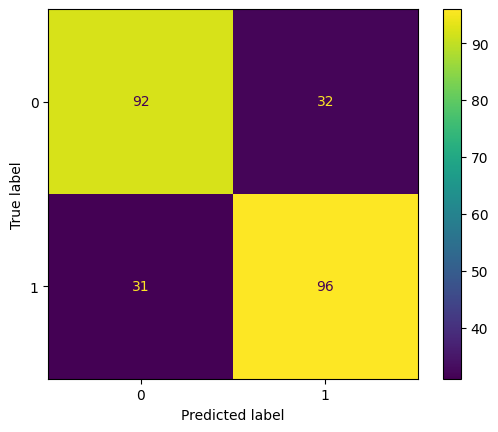

In [65]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

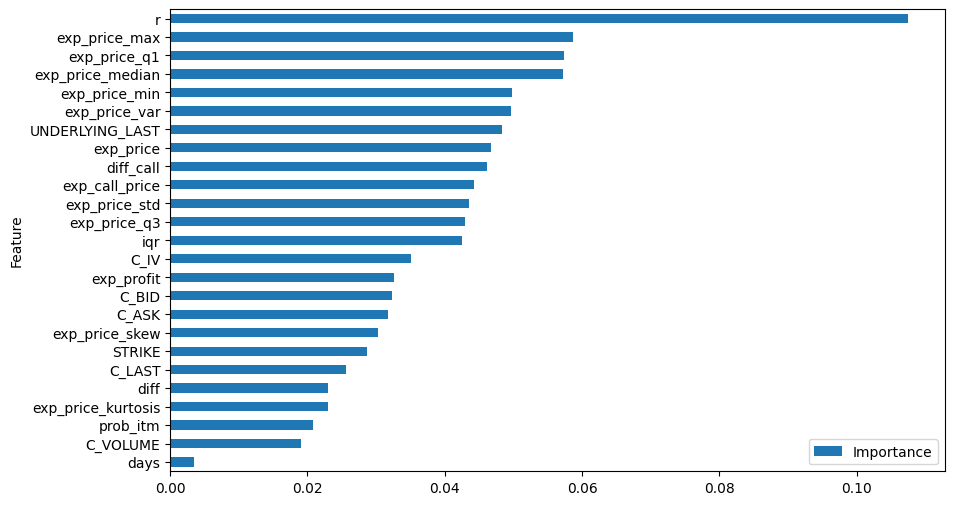

In [66]:
coefficients = best_model.named_steps["rf"].feature_importances_

feature_importance = pd.DataFrame({'Feature': new_df.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));